In [7]:
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np


## Rosenbrock function

The Rosenbrock function is a non-convex function by H.Rosenbrock. It is commonly used to evaluate optimization procedures. It has a norrow curved valley. In general finding the valley is easy, due to its steep walls. However, the valley floor is curved, with shallow gradients making it hard to achieve the global minimum.

$\large f(x,y) = (a-x)^2 + b(y-x^2)^2$

The function has a global minimum at $(a,a^2)$, with $f(a,a^2) = 0$

Other test functions for optimization can be found in [wikipedia](https://en.wikipedia.org/wiki/Test_functions_for_optimization).



In [8]:
def rosenbrock(x,y, a = 1, b = 10):
    return (a - x)**2 + b * (y - x**2)**2

In [9]:
# settings for function evaluation

a = 1
b = 10
xx = np.linspace(-2, 2, 100)
yy = np.linspace(-1, 3, 100)

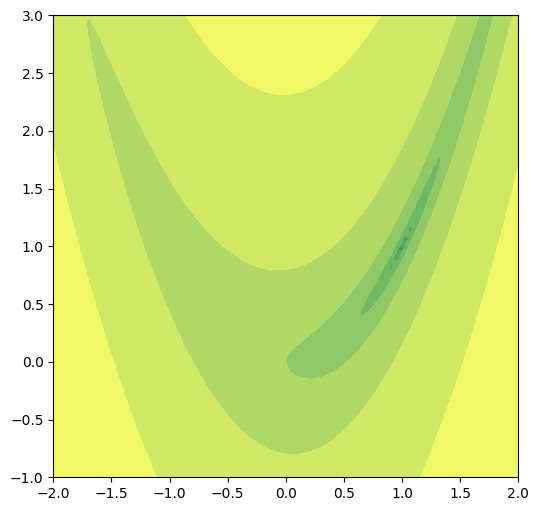

In [10]:
zz = np.asarray([[rosenbrock(x,y,a,b) for x in xx] for y in yy])
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, np.log(zz), cmap=cm.summer)

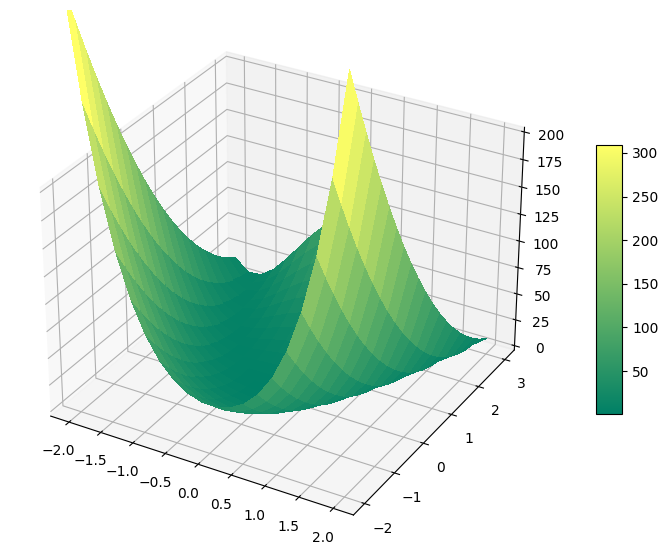

In [11]:
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

# Initialize figure 
figRos = plt.figure(figsize=(12, 7))
#axRos = figRos.gca(projection='3d')
axRos = plt.axes(projection='3d')
# Evaluate function
X = np.linspace(-2, 2, 20)
Y = np.linspace(-2, 3, 20)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X,Y)

# Plot the surface
surf = axRos.plot_surface(X,Y,Z, cmap=cm.summer,
                       linewidth=0, antialiased=False)
axRos.set_zlim(0, 200)
figRos.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

## Optimizers

Deep learning optimizers are commonly iterative procedures based on gradient information. In here the following optimizers will be presented:

* Gradient descent
* Gradient descent with momentum
* RMSProp
* Adam
* Adamax

For the Rosenbrock function the gradient can be computed as:

$\large g(x,y) =  {\large(\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}) }= (2(x-1) - 4b*(y - x^2)x, 2b(y-x^2))$


In [12]:
# function to compute the partial derivatives

def df_rosenbrock(P,a=1, b=10):
    x = P[0]
    y = P[1]
    return (2*(x-1) - 4*b*(y - x**2)*x, 2*b*(y-x**2))

In [13]:
# general parameters for all optimizers

steps = 100
start = [-1.8,2.6]

In [14]:
# aux function to plot contours and optimizer path

def plot_optimizer(xx,yy,zz,path):
    plt.figure(figsize=(8, 8))
    plt.contour(xx,yy,zz,250, cmap=cm.plasma)


    plt.plot([start[0]],[start[1]],marker='o',markersize=4, color ='g')
    for i in range(steps):
        plt.plot([path[i][0]],[path[i][1]],marker='o',markersize=2, color ='r')
        plt.arrow(path[i][0], path[i][1],path[i+1][0]-path[i][0], path[i+1][1]-path[i][1], head_width=0.05, head_length=0.05, fc='r', ec='r')
    
    plt.plot([1],[1],marker='o',markersize=2, color ='b')    

### Gradient Descent

This is the plain version, just follow the inverse direction of the gradient. Assuming $p$ is our initial guess, and f is the function we want to find the minimum of:

$\nabla f = \large (\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}) $

$\large p = p - \alpha \nabla f$

where $\alpha$ is the learning rate

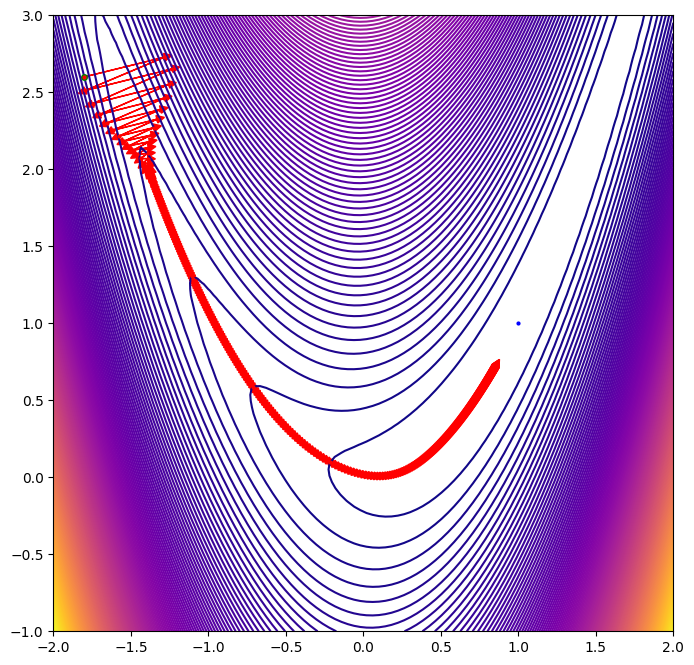

In [19]:
# Gradient descent

steps = 200
lr = 0.01
point = start
gx = [point]
for i in range(steps):
    df = df_rosenbrock(point)
    point -= lr * np.asarray(df);
    gx.append(list(point))

plot_optimizer(xx,yy,zz,gx)

### Gradient descent with Momentum

Momentum is an extension to gradient descent optimization that provides a stronger push in directions 
where the history of gradients agree

$ \Delta(i) = \alpha \nabla f_i + m \Delta(i-1)$

$ \large p = p - \Delta(i)$

Parameters:

* $m = 0.9$

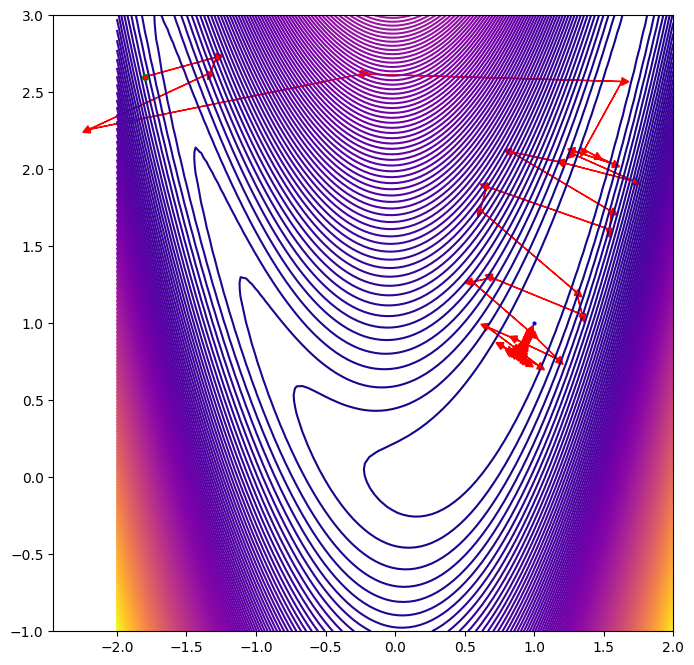

In [20]:
# Gradient descent with momentum

# parameters
steps = 200
lr= 0.01
m = 0.9

# init
point = start
gx = [point]

#do it
prev_step = np.asarray((0.0,0.0))
for i in range(steps):
    df = df_rosenbrock(point)
    step = - lr * np.asarray(df)
    point += step + m * prev_step;
    prev_step = step
    gx.append(list(point))

plot_optimizer(xx,yy,zz,gx)

### RMSProp (Root Mean Square Propagation)

As can be seen above, the sign of the gradient is a very usefull information, however, the magnitude can be way off: 

* when on the wall of the valley the gradient can overshoot the target taking us to the other side of the valley, potentially at a greater height than before;

* on the other hand, when close to the target gradients tend to be shallow, hence, gradients have very small magnitude, taking a long time to actually acheive the minimum.

In the first case we need a small learning rate, whereas in the latter example we need a large learning rate.

$\large v_i = \beta v_{i-1} + (1 - \beta) (\nabla f)^2$

$ \large p = p - \alpha \Large \frac{\nabla f}{\sqrt{v_i} + \epsilon}$

$v$ is like a moving average of the squared length on each direction, or magnitude. Dividing by $\sqrt{v}$ is similar to a normalization procedure. Larger gradients are divided by larger values, smaller gradients are divided by smaller values.


Pytorch default parameters:

* $\beta = 0.99$
* $\epsilon = 1e-08$

Tensor flow default parameters:

* $\beta = 0.9$
* $\epsilon = 1e-07$


Ref: Geoffrey Hinton, **RMSProp: Divide the gradient by a running average of its recent magnitude** [Video](https://www.youtube.com/watch?v=XhZahXzEuNo)

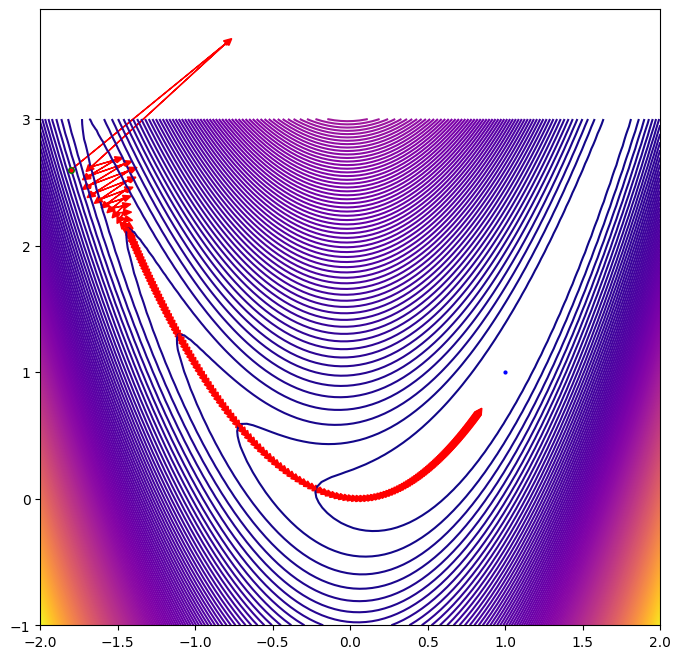

In [25]:
# rmsprop

# parameters
steps = 200
lr = 0.1
beta = 0.99
epsilon = 1e-08

#init
vdw = 0

point = start
gx = [point]
prev_df = np.asarray((0.0,0.0))

#do it
for i in range(steps):
    df = df_rosenbrock(point)
    vdw = beta * vdw + (1-beta)* np.asarray(df)**2
    point -= lr *  np.asarray(df) / (np.sqrt(vdw) + epsilon)
    gx.append(list(point))

plot_optimizer(xx,yy,zz,gx)



### Adam

Adam is one of the most popular optimizers. The intuition: join RMSProp and Momentum.

Moving average of gradient

$ \large m_i =  \beta_1 m_{i-1}+ (1-\beta_1)\nabla f $ 

Moving average of square gradient

$ \large v_i =  \beta_2 v_{i-1} + (1-\beta_2)(\nabla f)^2$

If the starting point has small values, common in DNN, and considering $m_0 = v_0 = 0$, $m_i$ and  $v_i$ will be too small. The following is a way to fix this. As $i$ increases, $\hat{m_i}$ and $\hat{v_i}$ will converge to $m_i$ and $v_i$, respectively.

$\large \hat{m_i} = \Large \frac{m_i}{1-\beta_1^i} , \hat{v_i} = \Large \frac{v_i}{1-\beta_2^i} $

$\large p_i = p_{i-1} - \alpha \Large \frac{\hat{m_i}}{\sqrt{\hat{v_i}} + \epsilon}$

Default parameters:

* $\beta_1 = 0.9$
* $\beta_2 = 0.999 $
* $\epsilon = 1e-08$

An advantage of this procedure is that we can start with a higher learning rate

Ref: Diederik P. Kingma, Jimmy Ba, **Adam: A Method for Stochastic Optimization** [PDF](https://arxiv.org/abs/1412.6980)

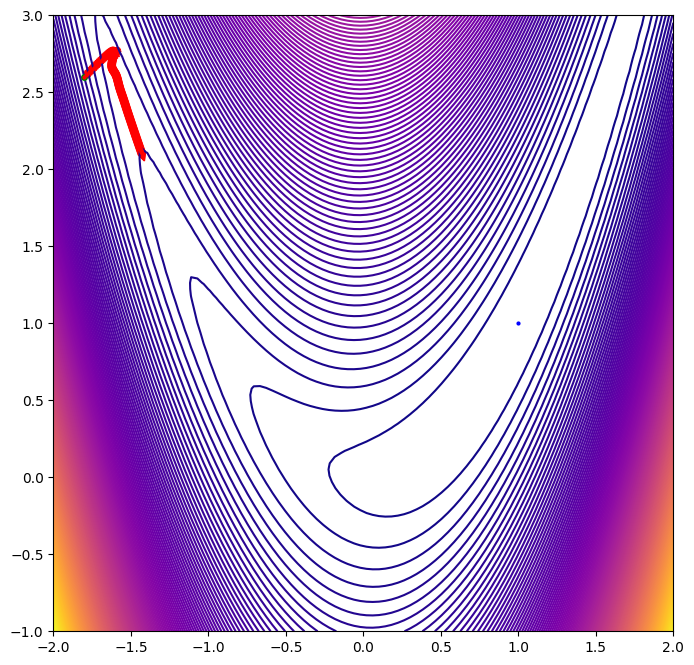

In [23]:
# adam

# parameters
lr = 0.01
steps = 200
beta1 = 0.9
beta2 = 0.999
epsilon=1e-07

#init
mdw = 0
vdw = 0 
point = start
gx = [point]
prev_df = np.asarray((0.0,0.0))

#do it
for i in range(steps):
    
    df = np.asarray(df_rosenbrock(point))
    
    mdw = beta1 * mdw + (1.0 - beta1) * df
    vdw = beta2 * vdw + (1.0 - beta2) * df**2
    
    mdw_corr = mdw / (1.0 - np.power(beta1, i + 1.0))
    vdw_corr = vdw / (1.0 - np.power(beta2, i + 1.0))
    
    point -= lr *  mdw_corr / (np.sqrt(vdw_corr)+ epsilon )
    gx.append(list(point))

plot_optimizer(xx,yy,zz,gx)  
    

### Adamax

$ \large m_i = \beta_1 m_{i-1} + (1-\beta_1)\nabla f$ 

$\large \hat{m_i} = \Large \frac{m_i}{1-\beta_1^{i}} $

$ \large s_i = max( \beta_2 * s_{i-1}, abs(\nabla f))$

$ \large p_i = p_{i-1} -  \alpha \Large \frac{\hat{m_i}}{s_i + \epsilon}$

Parameters:

* $\beta_1 = 0.9$
* $\beta_2 = 0.999$


Ref: Diederik P. Kingma, Jimmy Ba, **Adam: A Method for Stochastic Optimization** [PDF](https://arxiv.org/abs/1412.6980)

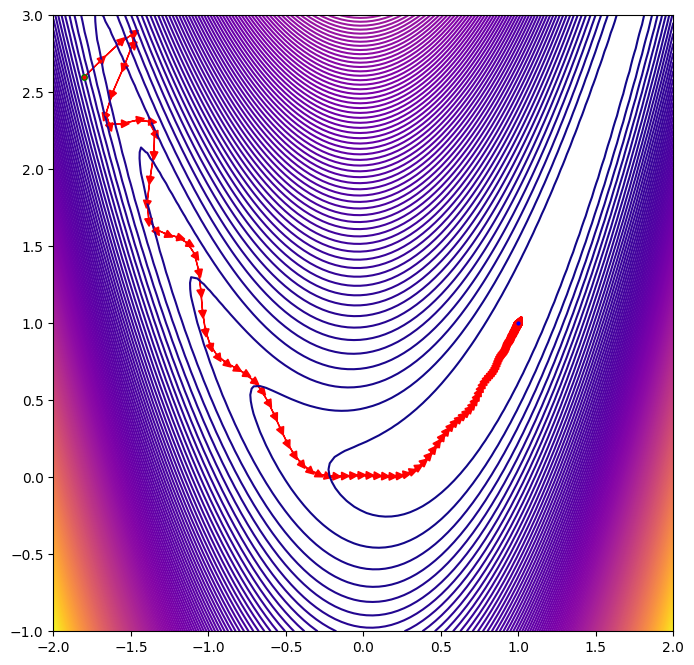

In [115]:

# adammax

lr = 1
steps = 200
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-07

m = 0
s = 0
point = start
gx = [point]
prev_df = np.asarray((0.0,0.0))

for i in range(steps):
    
    df = np.asarray(df_rosenbrock(point))
    m = beta1 * m + (1 - beta1) * df
    s = np.maximum(beta2 * s, np.abs(df))

    curr_lr = lr #/ (1 - beta1 ** (i+1))
    
    point -= curr_lr *  m / (s + epsilon )
    
    gx.append(list(point))    

plot_optimizer(xx,yy,zz,gx)    

## Suplementary Refs

* Sebastian Ruder, **An overview of gradient descent optimization algorithms**, [PDF](https://arxiv.org/abs/1609.04747)
* PyTorch documentation, **TORCH.OPTIM**, [LINK](https://pytorch.org/docs/stable/optim.html)
* Tensorflow documentation, **Module: tf.keras.optimizers**, [LINK](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)